In [107]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [119]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

usedu_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [120]:
usedu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In [121]:
usedu_df.isnull().sum()/usedu_df.shape[0]*100

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                          17.627346
TOTAL_REVENUE                   14.209115
FEDERAL_REVENUE                 14.209115
STATE_REVENUE                   14.209115
LOCAL_REVENUE                   14.209115
TOTAL_EXPENDITURE               14.209115
INSTRUCTION_EXPENDITURE         14.209115
SUPPORT_SERVICES_EXPENDITURE    14.209115
OTHER_EXPENDITURE               17.627346
CAPITAL_OUTLAY_EXPENDITURE      14.209115
GRADES_PK_G                     11.595174
GRADES_KG_G                      8.847185
GRADES_4_G                       8.780161
GRADES_8_G                       8.780161
GRADES_12_G                      8.780161
GRADES_1_8_G                     8.780161
GRADES_9_12_G                    8.780161
GRADES_ALL_G                    11.595174
AVG_MATH_4_SCORE                64.075067
AVG_MATH_8_SCORE                64.343164
AVG_READING_4_SCORE             64

### Dealing with missing values strategy:
- AVG_MATH & AVG_ READING columns are missing the majority of the data (65%). The data from these columns can be used to answer specific question about certain states where this proportion of data could be satisfactory to represent of the population. Otherwise, these columns can be eliminated from consideration.

In [122]:
ncol = usedu_df.shape[1]
cols = list(range(ncol-4, ncol))
usedu_df.drop( usedu_df.columns[cols], axis=1, inplace=True)
usedu_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,NaN,174053.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,NaN,37451.0,2371.0,10152.0,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,NaN,609114.0,2544.0,53497.0,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,NaN,145212.0,808.0,33511.0,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,NaN,2044688.0,59067.0,431763.0,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0


- Enrollment data is missing for 2012. Let's look at the distribution of number of enrolled students for a particular state and see how much variability there is accross the years

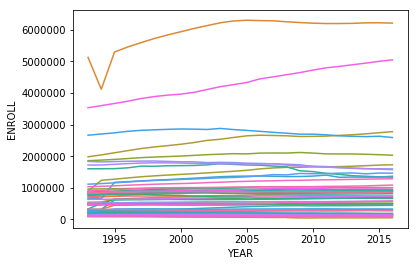

In [112]:
example_state = 'CALIFORNIA'
ax = sns.lineplot(x='YEAR', y='ENROLL', hue='STATE', data=usedu_df[(usedu_df['ENROLL'].notnull())], legend=False)


- Almost all states have a steady enrollment. Therefore, using mean to replace missing values would be a safe choice.

In [123]:
usedu_df['ENROLL'] = usedu_df.groupby('STATE')['ENROLL'].transform(lambda x: x.fillna(x.mean()))
pd.isnull(usedu_df.ENROLL).sum()/usedu_df.shape[0]*100

10.79088471849866

- The remaining 10% could be small districts/ 'states' that don't have a mean. How many other values are missing for these districts?

In [124]:
# subset of rows with ENROLL still Null
usedu_null_df = usedu_df[usedu_df['ENROLL'].isnull()]
print('{} row in this DataFrame subset'.format(usedu_null_df.shape[0]))
# percent of null per column for this subset
usedu_null_df.isnull().sum()/usedu_null_df.shape[0]*100

161 row in this DataFrame subset


PRIMARY_KEY                       0.000000
STATE                             0.000000
YEAR                              0.000000
ENROLL                          100.000000
TOTAL_REVENUE                   100.000000
FEDERAL_REVENUE                 100.000000
STATE_REVENUE                   100.000000
LOCAL_REVENUE                   100.000000
TOTAL_EXPENDITURE               100.000000
INSTRUCTION_EXPENDITURE         100.000000
SUPPORT_SERVICES_EXPENDITURE    100.000000
OTHER_EXPENDITURE               100.000000
CAPITAL_OUTLAY_EXPENDITURE      100.000000
GRADES_PK_G                      37.267081
GRADES_KG_G                      18.633540
GRADES_4_G                       18.012422
GRADES_8_G                       18.012422
GRADES_12_G                      18.012422
GRADES_1_8_G                     18.012422
GRADES_9_12_G                    18.012422
GRADES_ALL_G                     37.267081
dtype: float64

- These rows are missing all financial data and any analysis that concerns financial concepts should disregard these enteries.

In [125]:
print('nrow before= {}'.format(usedu_df.shape[0]))
usedu_df = usedu_df.drop( usedu_null_df.index.tolist() )
print('nrow after= {}'.format(usedu_df.shape[0]))

nrow before= 1492
nrow after= 1331


***
- Check how many values are still missing

In [129]:
usedu_df.isnull().sum()/usedu_df.shape[0]*100

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.000000
TOTAL_REVENUE                   3.831705
FEDERAL_REVENUE                 3.831705
STATE_REVENUE                   3.831705
LOCAL_REVENUE                   3.831705
TOTAL_EXPENDITURE               3.831705
INSTRUCTION_EXPENDITURE         3.831705
SUPPORT_SERVICES_EXPENDITURE    3.831705
OTHER_EXPENDITURE               7.663411
CAPITAL_OUTLAY_EXPENDITURE      3.831705
GRADES_PK_G                     8.489857
GRADES_KG_G                     7.663411
GRADES_4_G                      7.663411
GRADES_8_G                      7.663411
GRADES_12_G                     7.663411
GRADES_1_8_G                    7.663411
GRADES_9_12_G                   7.663411
GRADES_ALL_G                    8.489857
dtype: float64

In [153]:
# Missing financial values can be filled with corresponding mean of the state

revenue_cols = [col for col in usedu_df.columns if 'REVENUE' in col]
expenditure_cols = [col for col in usedu_df.columns if 'EXPENDITURE' in col]
before_impute = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values
usedu_df[revenue_cols] = usedu_df.groupby(['STATE'])[revenue_cols].transform(lambda x: x.fillna(x.mean()))
usedu_df[expenditure_cols] = usedu_df.groupby(['STATE'])[expenditure_cols].transform(lambda x: x.fillna(x.mean()))
after_impute = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).values
impute_ind = (usedu_df.isnull().sum()/usedu_df.shape[0]*100).index
for row in zip(impute_ind, before_impute, after_impute):
    print('{0:<30}      {1:<12}      {2:<12}'.format(*row))


PRIMARY_KEY                         0.0               0.0         
STATE                               0.0               0.0         
YEAR                                0.0               0.0         
ENROLL                              0.0               0.0         
TOTAL_REVENUE                       0.0               0.0         
FEDERAL_REVENUE                     0.0               0.0         
STATE_REVENUE                       0.0               0.0         
LOCAL_REVENUE                       0.0               0.0         
TOTAL_EXPENDITURE                   0.0               0.0         
INSTRUCTION_EXPENDITURE             0.0               0.0         
SUPPORT_SERVICES_EXPENDITURE        0.0               0.0         
OTHER_EXPENDITURE                   0.0               0.0         
CAPITAL_OUTLAY_EXPENDITURE          0.0               0.0         
GRADES_PK_G                         8.489857250187828      8.489857250187828
GRADES_KG_G                         7.66341096919609